In [ ]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

In [2]:
%cd ..
from src.manifolds.landmarks import *
M = landmarks(2)
print(M)

from src.plotting import *

/home/line/Dropbox
2 landmarks in R^2 (dim 4). kernel Gaussian, k_alpha=1, k_sigma=[[0.5 0. ]
 [0.  0.5]]


In [3]:
# Riemannian structure
from src.Riemannian import metric
metric.initialize(M)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


# Data preparation

(155, 65)
(65, 39, 2)


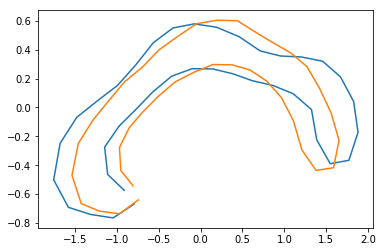

In [126]:
# load data
DIM = 2
from scipy import io
# load CC data...
data=io.loadmat('/home/line/Desktop/Regressiongpu/Regression/ipmi-data/dataM-corpora-callosa-ipmi-full.mat')

vi = data['vi'] # corpora callosa
Nsamples = vi.shape[1]
N0 = int(vi.shape[0]/2-1) - 1
#N.set_value(vi.shape[0]/DIM-1)
print(vi[0:(-3),:].shape)
qs = vi[0:(-4),:].T.reshape([Nsamples,N0,2])

# Reduce the number of landmarks:
qs = qs[:,np.arange(0,N0,2),:]
N0 = qs.shape[1]

qs = 1./20*qs # rescale
print(qs.shape)

%matplotlib inline
qsr = qs
m = np.mean(qsr,axis=0)
for i in np.array([0,16]):#Nsamples):
    plt.plot(qsr[i,:,0],qsr[i,:,1])
#plt.plot(m[:,0],m[:,1],linewidth=3,color = 'k')
#plt.savefig("sample.pdf")

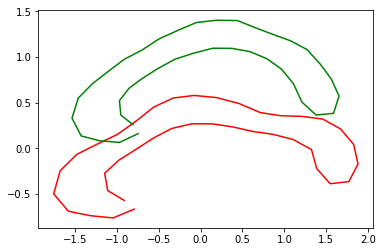

In [127]:
q = qsr[0,:,:]
q1 = qsr[16,:,:]
q1[:,1] = q1[:,1] + 0.8
plt.plot(q[:,0],q[:,1], 'r')
plt.plot(q1[:,0],q1[:,1], 'g')

# Geodesic

In [29]:
#x0 = np.mean(qs[:,:,:], axis = 0)
#ind = np.arange(0,N0,5)
#dist = np.zeros(5)
#for i in range(5):
#    dist[i] = np.sqrt(np.sum((x0[ind[i],:] - x0[ind[i]+1,:])**2))

M.k_sigma.set_value(np.diag((np.mean(dist),np.mean(dist))))
print("Sigma = ", M.k_sigma.get_value())

M.N.set_value(N0)

q = x0.flatten()
v = np.vstack((np.zeros((N0)),1*np.ones((N0)))).T.flatten()
print("q = ", q.shape, " v = ", v.shape)
p = M.flatf(q,v)

Sigma =  [[0.25823194 0.        ]
 [0.         0.25823194]]
q =  (78,)  v =  (78,)


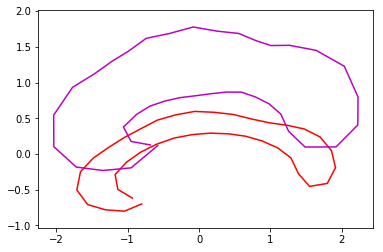

In [40]:
# Hamiltonian dynamics
#print(M.Hf(q,p))
#from src.dynamics import Hamiltonian
#Hamiltonian.initialize(M)

# geodesic
#qs = M.Exp_Hamiltoniantf(q,p).T
M.plot()
#M.plotx(qs, prevx=False,last=False, markersize=0.01)
ini = qs[0,:].reshape((M.N.eval(),2))
end = qs[-1,:].reshape((M.N.eval(),2))
plt.plot(ini[:,0], ini[:,1], 'r-')
plt.plot(end[:,0], end[:,1], 'm-')
#plt.savefig("geoCCmean.pdf")
plt.show()
#(ts,qps) = M.Hamiltonian_dynamicsf(q,p)
#ps = qps[:,1,:]
#print("Energy: ",np.array([M.Hf(q,p) for (q,p) in zip(qs,ps)]))

In [41]:
# Matching of two shapes:
from src.Riemannian import Log
Log.initialize(M,M.Exp_Hamiltonian)

In [128]:
vres = M.Logf(q.flatten(),q1.flatten())

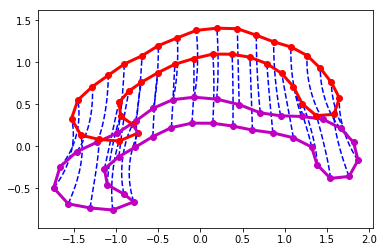

In [134]:
M.plot()
qs = M.Exp_Hamiltoniantf(q.flatten(),vres[0]).T
foox = qs[:,0::2]#.reshape((M.N.eval(),2))
fooy = qs[:,1::2]
for i in range(foox.shape[1]):
    #foo = qs[:,i].reshape((M.N.eval(),2))
    plt.plot(foox[:,i], fooy[:,i], 'b--')
#M.plotx(qs, prevx=False,last=False, markersize=0.01)
ini = qs[0,:].reshape((M.N.eval(),2))
end = qs[-1,:].reshape((M.N.eval(),2))
plt.plot(ini[:,0], ini[:,1], 'm-', linewidth=3)
plt.plot(end[:,0], end[:,1], 'r-', linewidth=3)
plt.plot(ini[:,0], ini[:,1], 'mo', linewidth=3)
plt.plot(end[:,0], end[:,1], 'ro', linewidth=3)
plt.plot(np.array([ini[0,0],ini[-1,0]]), np.array([ini[0,1],ini[-1,1]]), 'm-', linewidth=3)
plt.plot(np.array([end[0,0],end[-1,0]]), np.array([end[0,1],end[-1,1]]), 'm-', linewidth=3)
plt.savefig("CC_deform.pdf")
#plt.show()

In [6]:
x0 = np.mean(qs[:,:,:], axis = 0)
ind = np.arange(0,N0,5)
dist = np.zeros(5)
for i in range(5):
    dist[i] = np.sqrt(np.sum((x0[ind[i],:] - x0[ind[i]+1,:])**2))

k_sigma.set_value(np.diag((np.mean(dist),np.mean(dist))))
print("Sigma = ", k_sigma.get_value())

N.set_value(N0)
#x0 = qs[0,:,:]
q0 = x0.flatten()

v0 = np.tile(np.array([0,1]), N.eval()).reshape(N.eval(),2)
p0 = gMflatf(q0,v0.flatten())
print(p0)

plt.plot(x0[:,0],x0[:,1], 'ro')
plt.quiver(x0[:,0],x0[:,1],v0[:,0],v0[:,1], scale = 12)
plt.axis((np.min(x0[:,0])-0.5,np.max(x0[:,0])+0.5,np.min(x0[:,1])-0.1,
          np.max(x0[:,1])+0.5))
#plt.savefig("geoCCmean.pdf")

NameError: name 'k_sigma' is not defined

In [ ]:
# Hamiltonian dynamics
from src.Hamiltonian import *
# test Hamiltionian and gradients
print(p0)
print(Hf(q0,p0))

# geodesic
start = time.time()
qsv = Exptf(q0,p0).T
diff = time.time() - start
print("Time for geodesic = ", diff)
%matplotlib inline
plt.figure()
plt.axis('equal')
plotx(qsv,linewidth=2)
qf = qsv[-1,:].reshape((N.eval(),2))
plt.plot(qf[:,0],qf[:,1], 'ro')
plt.plot(qf[:,0],qf[:,1], 'r-',linewidth=3)
plt.plot(x0[:,0],x0[:,1], 'b--')
plt.show()
(ts,qpsv) = Hamf(q0,p0)
psv = qpsv[:,1,:]
print("Energy: ",np.array([Hf(q,p) for (q,p) in zip(qsv,psv)]))
#plt.savefig("geoCC.pdf")

# Parallel Transport

In [ ]:
rank.set_value(d.eval())
v0 = np.tile(np.array([1,0]), N.eval()).flatten()
t = np.linspace(0,2,n_steps.get_value()+1)
gamma0 = np.vstack((x0.flatten(),qsv))

diffgamma0 = np.diff(gamma0, axis = 0)/dt.eval()

In [ ]:
# Parallel transport
from src.parallel_transport import *
# test parallel transport
v0 = np.tile(np.array([0,1]), N.eval()).flatten()
vt0 = partransf(v0,gamma0,diffgamma0)

In [ ]:
v0 = np.tile(np.array([1,0]), N.eval()).flatten()
vt1 = partransf(v0,gamma0,diffgamma0)

In [ ]:
cur = gamma0.reshape((n_steps.eval()+1,N.eval(),2))
ptv1 = vt1.reshape((n_steps.eval(),N.eval(),2))
ptv0 = vt0.reshape((n_steps.eval(),N.eval(),2))
ne = np.array([5,8,12,16,20])
print(ne)
qf = qsv[-1,:].reshape((N.eval(),2))
plt.plot(qf[:,0],qf[:,1], color='r',marker='o',linestyle='')
plt.plot(x0[:,0],x0[:,1], color='0.5', marker='o',linestyle='')
#plt.plot(qf[:,0],qf[:,1], color='0.75', linestyle='-',linewidth=1)
for i in range(N.eval()):
    plt.plot(cur[:,i,0],cur[:,i,1], 'b--')
    sg = np.array([1,99])
    
    if i in ne:
        for j in range(sg.shape[0]):
            plt.quiver(cur[sg[j],i,0],cur[sg[j],i,1],ptv1[sg[j],i,0],ptv1[sg[j],i,1],
                      pivot='tail',linewidth=4,scale=10)
            plt.quiver(cur[sg[j],i,0],cur[sg[j],i,1],ptv0[sg[j],i,0],ptv0[sg[j],i,1],
                      pivot='tail',linewidth=4,scale=10)
plt.axis((-2.6,2.9,-1.4,3))
#plt.axis('equal')
#plt.plot(x0[:,0],x0[:,1], 'b--')
#plt.axis((-3,3,-1.5,3))
#plt.savefig("partrans.pdf")

# Development and Stochastic Development

### Development

In [ ]:
n_steps.set_value(50)
ui0 = np.tile(np.array([1.,0,0,1.]), N.eval()).reshape(2*N.eval(),rank.eval())
ui0 = GramSchmidt(ui0,x0.flatten()) #sp.linalg.orth(v0)
rank.set_value(2)

q0 = np.hstack([x0.flatten(),ui0.flatten()]).astype(theano.config.floatX)
print("q0 = ", q0)

# Curve in R^2:
t = np.linspace(0,10,n_steps.get_value()+1)
gamma0 = np.vstack([5*np.sin(t), (t**2 + 2*t)/10]).T
dgamma0 = np.diff(gamma0, axis = 0)
print("dgamma.shape =", gamma0)

In [ ]:
%matplotlib inline
plt.plot(gamma0[:,0],gamma0[:,1])
plt.plot(gamma0[0,0],gamma0[0,1], 'ro')
plt.plot(gamma0[-1,0],gamma0[-1,1],'go')
#plt.axis((-21,21,-11,131))
#plt.savefig("landDev1.pdf")

In [ ]:
# Development dynamics
from src.Stochastic_Development import *
# test deterministic development
start = time.time()
qsv = devf(q0,dgamma0)
diff = time.time() - start
print("Time for development = ", diff)
plt.figure()
plotFMx(np.concatenate([q0.reshape((1,len(q0))),qsv]),N_vec = 0)
plt.show()
#plt.savefig("landDev2.pdf")

### Stochastic development:

In [ ]:
n_steps.set_value(200)
ui0 = np.tile(np.array([1.,0,0,1.]), N.eval()).reshape(2*N.eval(),rank.eval())
ui0 = GramSchmidt(ui0,x0.flatten())

q0 = np.hstack([x0.flatten(),ui0.flatten()]).astype(theano.config.floatX)
print("q0 = ", q0)

# srng.seed(422)

dWt0 = np.random.normal(0, np.sqrt(dt.eval()), (n_steps.get_value(),2))/2
drift0 = np.array([0.1,0.1])

In [ ]:
dZt = dWt0 + drift0*dt.eval()
Zt = np.concatenate([np.array([0,0]).reshape((1,2)),np.cumsum(dZt, axis = 0)])
plt.plot(Zt[:,0],Zt[:,1],'b-',linewidth = 1)
plt.plot(0,0, 'ro')
plt.plot(Zt[-1,0],Zt[-1,1], 'go')
#plt.savefig("stoc.pdf")

In [ ]:
from src.Stochastic_Development import *
# test stochastic development
start = time.time()
qsv = stoc_devf(q0,dWt0,drift0)
diff = time.time() - start
print("time = ", diff)

plt.figure()
plotFMx(np.concatenate([q0.reshape((1,len(q0))),qsv]),N_vec = 0)
plt.show()
#plt.savefig("landstoc2.pdf")

In [ ]:
plt.figure()
#plt.axis('equal')
endq = qsv[-1,0:d.eval()].reshape((N.eval(),2))
plotFMx(np.concatenate([q0.reshape((1,len(q0))),qsv]),N_vec = None,
         color='0.4')
plt.plot(endq[:,0],endq[:,1],'ro')
plt.plot(endq[:,0],endq[:,1],'r-')
plt.plot(x0[:,0],x0[:,1],'b-')
plt.plot(x0[:,0],x0[:,1],'bo')
plt.show()
#plt.savefig("stocCC.pdf")

# Frechet Mean

In [ ]:
n_samp = 10
N.set_value(N0)

q0 = np.mean(qs[:,:,:], axis = 0).flatten()
y0 = qs[0:n_samp,:,:].reshape((n_samp,N.eval()*2))

v0 = np.tile(np.array([0,1]), N.eval()).reshape(N.eval(),2)
v0 = GramSchmidt(v0.flatten(),q0)
p0 = gMflatf(q0,v0)

In [ ]:
# Frechet mean
from src.Frechet_mean import *

start = time.time()
mf = Frechet_mean(y0,q0,p0)
diff = time.time() - start
print("time = ", diff)
print("loss = ", mf[1])
print("mean = ", mf[0])

#%matplotlib notebook
qopt = mf[0]
itera = mf[2]
newfig()
plotM(rotate = np.array([50,-45]))
plotMean(qopt,y0,itera)
plt.show()

# Brownian motions in coordinates

In [ ]:
# Brownian motion
from src.Brownian_coords import *

# sample for Brownian motion transition distribution
N_samples = 10
obss = np.zeros((N_samples,)+q0.shape)
qsvs = np.zeros((N_samples,n_steps.eval(),)+q0.shape)
# srng.seed(422)
for i in range(N_samples):
    (ts,qsv) = Brownian_coordsf(q0,0.1*dWsf())
    qsvs[i] = qsv
    obss[i] = qsv[-1]

In [ ]:
def plotx(x,ui=None,color='b',color_intensity=1.,linewidth=1.,prevx=None,last=True,curve=False,markersize=None):
    if len(x.shape)>1:
        for i in range(x.shape[0]):
            plotx(x[i],ui=ui if i==0 else None,
                  color=color,
                  color_intensity=color_intensity if i==0 or i==x.shape[0]-1 else .7,
                  prevx=x[i-1] if i>0 else None,
                  last=i==(x.shape[0]-1),
                  curve=curve)
        return
    
    x = x.reshape((-1,m.eval()))
    NN = x.shape[0]
    
    for j in range(NN):  
        if prevx is last:
            plt.scatter(x[j,0],x[j,1],color='b',s=markersize)
        if prevx is not None:
            prevx = prevx.reshape((NN,m.eval()))
            xx = np.stack((prevx[j,:],x[j,:]))
            plt.plot(xx[:,0],xx[:,1],linewidth=linewidth,color='b')

        if ui is not None:
            ui = ui.reshape((NN,m.eval()))
            plt.quiver(x[j,0],x[j,1],ui[j,0],ui[j,1],pivot='tail',linewidth=linewidth,scale=5)
    if curve and last:#(last or prevx is None):
        plt.plot(np.hstack((x[:,0],x[0,0])),np.hstack((x[:,1],x[0,1])),'o-',color=color)

In [ ]:
plot_samples = 1
colors=[colormap(k) for k in np.linspace(0, 1, plot_samples)]
plotx(q0,color='k',curve=True)
for i in range(plot_samples):
    plotx(qsvs[2+i],color='r',curve=True)#colors[i],curve=True)
plt.axis('equal')
plt.show()
#plt.savefig('browncoord.pdf')

# Samples from Normal distribution

In [ ]:
colormap = plt.get_cmap('winter')
plot_samples = 10
colors=[colormap(k) for k in np.linspace(0, 1, 2)]#plot_samples)]
for i in range(2,plot_samples):
    plotx(obss[i],curve=True,color='0.75')
plotx(q0,color='k',curve=True)
for i in range(2):
    plotx(obss[i],curve=True,color=colors[i])
plt.axis('equal')
#plt.savefig('normsamples.pdf')
plt.show()